# Helmet Classification For TinyML Project

> 이 notebook 은 open source 컨트리뷰톤 2020 - tinyML (Tensorflow Lite Project) Mobility Team 의 오픈소스 프로젝트를 위해 만들어졌습니다. 

- 모빌리티 팀 (멘토 맹윤호)
- 최예진(팀장), 이민우, 전수민, 이장후, 이경환, 조승현
- **.ipynb 제작 - 이장후. 2020/08/29**
- **.ipynb 수정자 -**

<br>

- Target Github Repository : [TinyML : Tensorflow lite for microcontroller](https://github.com/yunho0130/tensorflow-lite)
- Team Github Repository : [TinyML-Mobility](https://github.com/orgs/tinyml-mobility/teams)

<br>

## Before We Start
- 런타임 -> GPU 로 변경 하셨나요?

<br>

## This Time
- keras 내장 모델인 mobilenet v2 를 불러오지 말고, 직접 mobilenet v2 를 구현해 봅시다.


# Google Drive

- 학습을 시키기 전 데이터가 있는 google Drive 와 연동을 해야 합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Include Library

- 이 노트북의 소스코드는 tensorflow 2.0 이상과 호환되지 않습니다.
- Google colab 에서는 %tensorflow_version 을 통해, 원하는 버전의 tensorflow 를 쉽게 불러올 수 있습니다

In [ ]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

## Hyper Parameters
- 하이퍼파라미터들을 위에 모아서 정의해두는 습관
- google colab 에서는 아까 언급했던 % magic 을 이용해서 tensorboard 를 쉽게 사용할 수 있도록 만들어 두었습니다. (그런데 잘 돌아가지는 않음)

In [ ]:
%load_ext tensorboard

In [ ]:
%cd /content/gdrive/"My Drive"/data/

# 데이터가 존재하는 경로 ( /content/gdrive/"My Drive"/data/helmetclassification ) 를 data_dir 변수에 저장합니다.
data_dir = os.path.join(os.getcwd(), 'helmetclassification')
print(data_dir)

# input 이미지의 크기는 224 by 224 by 3 이 모델이 제안하는 기본값입니다. 
# 하지만 지난번 예제와 같이, 조금 줄일 수도 있는데, 우리가 데이터로 가지고 있는 이미지의 해상도가 충분히 좋다면,
# input 이미지의 기본 크기를 크게 잡아 주어도 됩니다. 즉, 상황에 따라 다르게 조정해 줄 수 있습니다.
# 그 이유는, 모든 resize 를 끝내고, 찌그러지거나 강제로 확장된 이미지가 네트워크를 통과하게 되는 원리이기 때문입니다.
# 이번에는, 그냥 기본 사이즈로 해보도록 하겠습니다.
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNEL = 3 # 채널은 RGB 이므로, 3 입니다.
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

# 연산 처리 단위 (배치) 는 이미지 16장, 그리고 Learning Rate, optimizer, 에폭 등을 설정합니다.
# *참고* : Optimizer 에서 SGD 는 최근 잘 사용하지 않지만, 안정적인 수렴을 위해 특정 경우에 사용합니다. 
BATCH_SIZE = 16
LEARNING_RATE_SGD = 0.001
LEARNING_RATE_ADAM = 0.0001
TRAINING_OPTIMIZER_SGD  = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE_SGD, momentum=0.0)
TRAINING_OPTIMIZER_ADAM = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM)
EPOCHS = 50

# 우리는 checkpoint 를 설정해서, 각 epoch 마다 가중치를 저장할 것입니다.
CKPT_DIR = os.path.join(data_dir, 'checkpoint')

# 우리는 h5 file 을 tflite 파일로 전환할 것입니다. 이름을 미리 정해 둡시다.
SAVED_KERAS_MODEL_NAME = 'helmet_classification_model_handmaded_mobilenet.h5'

# 우리는 잠시 후에 라벨 파일을 만들어낼 것인데, 라벨 파일의 이름을 미리 정의해 둡시다.
LABEL_FILE_NAME = 'ishelmetlabel.txt'

## Generator
- python 에는 '제네레이터' 라는 것이 존재합니다.
- 그 때 그 때, 상황에 맞는 데이터를 만들어 주는 역할을 수행합니다.
- keras 에서는, 이를 이용하여, 우리가 가지고 있는 image data 들을 정갈하게 정리해서 하나씩 하나씩 필요에 맞게 넘겨 주는 함수를 만들어 두었습니다. 

<br>

### ImageDataGenerator : Data Augmentation
- Data Augmentation 은 말 그대로 데이터를 증폭시켜주는 역할을 합니다.
- 고양이 사진이 있을 때, 고양이 머리만 있어도 고양이이고, 몸통만 있어도 고양이이며, 형광등 아래의 고양이도 고양이고, 백열등 아래의 고양이도 고양이입니다.
- 우리가 가지고 있는 이미지를 인위적으로 변형한 뒤에도, 올바르게 추론할 수 있도록 이미지 데이터를 다양한 방법으로 변형시켜줄 수 있도록 돕는 함수가 Keras 의 ImageDataGenerator 입니다.
- Train 할 때는 이미지를 변형해서 forward-pass 시켜주지만, test 를 할 때에는 이미지를 변형해서 네트워크를 통과시키면 안 되겠지요.
- 다만, Train 이나 Test 시에는 Network 의 사양에 맞추어서 0~1 의 범위로 input 을 정규화 시켜 주어야 합니다.

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1./255,
    dtype='float',
    fill_mode="nearest",
    horizontal_flip=True,
    channel_shift_range=0.1, 
    rotation_range=20,
    brightness_range=(-0.3, 0.3)
    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    dtype='float',
    validation_split=0.8
    )

## Check Directory
- 잘 정리되었나 확인해 봅시다
- train, test 폴더만 남아 있어야 합니다.
- 각 디렉터리에 이미지 개수들이 적절히 잡혀야 합니다.

In [ ]:
import os
%cd /content/gdrive/"My Drive"/data/helmetclassification/
!ls

In [ ]:
# helmet
%cd /content/gdrive/"My Drive"/data/helmetclassification/train/helmet/
file_list = os.listdir(os.getcwd())
print('count of train helmet file :', len(file_list))

In [ ]:
# helmet
%cd /content/gdrive/"My Drive"/data/helmetclassification/test/helmet/
file_list = os.listdir(os.getcwd())
print('count of test helmet file :', len(file_list))

In [ ]:
# non_helmet
%cd /content/gdrive/"My Drive"/data/helmetclassification/train/non_helmet/
file_list = os.listdir(os.getcwd())
print('Count of train non_helmet file :', len(file_list))

In [ ]:
# non_helmet
%cd /content/gdrive/"My Drive"/data/helmetclassification/test/non_helmet/
file_list = os.listdir(os.getcwd())
print('Count of test non_helmet file :', len(file_list))

## Data Generator Flow From Directory
- Keras 는 Directory 이름과 해당 폴더로부터 알아서 클래스를 구분해주고, 쉽게 training 시킬 수 있도록 API 를 제공합니다.
- train_generator : generator 로써, next() 수행 시 하나의 tensor 를 만들어냅니다.
  - 한 번에 만들어내는 tensor 은 (image tensor, label tensor) 이고, 그 shape 은 (batch_size, 224, 224, 3)  (batch_size, 2 - 클래스가 2개이므로) 입니다.
- val_generator : generator 로써, 이하동문.
  - 한 번에 만들어내는 tensor 은 (image tensor, label tensor) 이고, 그 shape 은 (1, 224, 224, 3)  (1, 2) 입니다.


In [ ]:
print('Training data generator during training session')
train_generator = train_datagen.flow_from_directory(
    data_dir+'/train',
    color_mode="rgb",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    )

print('\nValidation data generator during training session')
val_generator = test_datagen.flow_from_directory(
    data_dir+'/test',
    color_mode="rgb",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    subset="training"
    )

print('\nTest data generator when the end of training session')
test_generator = test_datagen.flow_from_directory(
    data_dir+'/test',
    color_mode="rgb",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    subset="validation"
    )

# Model For training
- 이제 모델을 만들고, 훈련을 시켜 보도록 합시다.

### Model 직접 쌓아보기
- Part1 에서는 기본으로 제공되는 모델인 mobilenet v2 를 사용했습니다.
- 이번에는 mobilenet v2 를 직접 작성해 보도록 합시다.

*주의 : 직접 작성하는 모델과 직접 훈련시키는 가중치는, 기본으로 제공되는 모델과 가중치보다 성능이 떨어집니다.


### Mobilenet v2 의 구조
- mobilenet 에 대해서 모든 내용을 설명할 수 없습니다. 아래 링크를 통해 알아보고, 네트워크에 대해서 익숙하지 않으신 분들은, 아 이렇게 모델을 만드는 것과 학습이 연결이 되는구나 정도만 이해해도 좋을 것 같습니다.
- mobilenet v1 에 대한 설명 https://gaussian37.github.io/dl-concept-mobilenet/
- depth-separable convolution 에 대한 설명 https://gaussian37.github.io/dl-concept-dwsconv/
- mobilenet v2 에 대한 설명 https://gaussian37.github.io/dl-concept-mobilenet_v2/


```
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = True
```

### 재료
- mobilenet v2 는 다음과 같은 operator 들로 이루어져 있습니다.
- operator 이라고 한 것은, 하나의 모듈이라고 생각하면 됩니다.
  - convolution x 1
  - inverted residual x 5
  - convolution x 1
  - global average pooling layer x 1
  - convolution layer x 1 (fully connected layer 역할의 레이어)
- 우선 convolution operator 부터 만들어 볼까요?
  - mobilenet 에서 말하는 convolution 모듈 이란, 우리가 평소 생각하는 그냥 convolution 연산만 하는 것을 의미하는 것이 아니라, 아래 셋을 모두 포함하고 있는 모듈입니다.
    - 3 by 3 커널의 n stride 의 convolution 레이어
    - 배치 정규화 레이어
    - relu6 activation 레이어


In [ ]:
def _conv_block(inputs, filters, kernel, strides, name = None):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    # tensorflow 
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1

    if name is not None :
      x = tf.keras.layers.Conv2D(filters, kernel, padding='same', strides=strides, name = name)(inputs)
    else :
      x = tf.keras.layers.Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis)(x)
    return tf.keras.layers.Activation(relu6)(x)

from functools import wraps
@wraps(tf.keras.backend.relu)
def relu6(x):
    """Relu 6
    """
    return tf.keras.backend.relu(x, max_value=6.0)

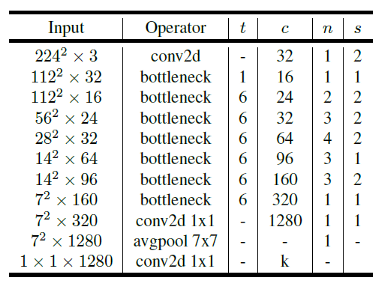

In [ ]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def _bottleneck(inputs, filters, kernel, t, width_multiplier, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        width_multiplier: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    
    # Depth
    tchannel = tf.keras.backend.int_shape(inputs)[channel_axis] * t

    # Width
    cchannel = int(filters * width_multiplier)

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis)(x)
    x = tf.keras.layers.Activation(relu6)(x)

    x = tf.keras.layers.Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis)(x)

    if r:
        x = tf.keras.layers.Add()([x, inputs])

    return x

# n 번 반복
def _inverted_residual_block(inputs, filters, kernel, t, width_multiplier, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        width_multiplier: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, width_multiplier, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, width_multiplier, 1, True)

    return x

이렇게 재료 함수들을 모두 만들었습니다.
- 하지만 원래 mobilenet 을 그대로 만들어 버린다면, 우리가 추론하고자 하는 것에 비해 모델이 너무 강력합니다! 
- 우리는 이 모델을 조금 더 단순화할 필요가 있습니다. 원래 상태보다 조금 더 간단하고 정보를 보존하는 모델로 개량해 보도록 해요.

In [ ]:
def MobileNetv2(input_shape, k, width_multiplier=1.0):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        width_multiplier: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
    # Returns
        MobileNetv2 model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)

    first_filters = _make_divisible(32 * width_multiplier, 8) # 그냥 잘 나누어떨어지게 하는 친구. mobilenet v2 은 모든 채널이 8의 배수로 나누어떨어짐.
    x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))
    x = _inverted_residual_block(x, 16, (3, 3), t=1, width_multiplier=width_multiplier, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, width_multiplier=width_multiplier, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, width_multiplier=width_multiplier, strides=2, n=2) # 원래 n = 3 입니다.
    x = _inverted_residual_block(x, 64, (3, 3), t=6, width_multiplier=width_multiplier, strides=2, n=2) # 원래 n = 4 입니다.
    x = _inverted_residual_block(x, 96, (3, 3), t=6, width_multiplier=width_multiplier, strides=1, n=2) # 원래 n = 3 입니다.
    x = _inverted_residual_block(x, 160, (3, 3), t=6, width_multiplier=width_multiplier, strides=2, n=2) # 원래 n = 3 입니다.
    # x = _inverted_residual_block(x, 320, (3, 3), t=6, width_multiplier=width_multiplier, strides=1, n=1)

    if width_multiplier > 1.0:
        last_filters = _make_divisible(320 * width_multiplier, 8) # 원래 channel : 1280 * width_multiplier 입니다.
    else:
        last_filters = 1280

    x = _conv_block(x, last_filters, (1, 1), strides=(1, 1), name='final_conv')
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2, activation="softmax")(x) # Convolution2D 와 사실상 같은 역할을 하는 layer 입니다.

    model = tf.keras.models.Model(inputs, output)

    return model

In [ ]:
full_model = MobileNetv2(IMG_SHAPE, 2, 1.0)
full_model.summary()

In [ ]:
full_model.compile(optimizer=TRAINING_OPTIMIZER_ADAM, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train
- 모델을 다 만들었으니 이제 훈련을 시킬 차례입니다.
- 그런데 훈련을 시작하게 되면, 개입이 불가능해집니다.
- 따라서 특정 타이밍(예를 들어, 1에폭마다) 적절히 호출되는 콜백 함수를 미리 등록시켜 두고, 훈련을 시작하는 것이 바람직합니다.
  - 중간중간 모델의 가중치를 세이브하는 기능
  - 텐서보드로 로그를 전송하는 기능
- 일반적으로 이 두 가지 기능을 callback 으로 등록시켜 두곤 합니다.
- keras_model.fit_generator() 함수가 호출되면 Training 이 시작됩니다.


In [ ]:
# 이렇게 직접 제작한 callback 을 만들수도 있습니다. 예제에서는 사용하지 않습니다.
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        data = val_generator.next()
        shape1 = data[0].shape
        answer_shape1 = data[1].shape
        dtype1 = data[0].dtype
        print("...Evaluating: start of batch {}; shape {} - dtype {}, {}; got log keys: {}\n".format(batch, shape1, dtype1, answer_shape1, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [ ]:
# checkpoint 를 저장합니다. checkpoint 파일은 cp-<저장하는 시간>-<에폭에 해당하는 네자리수>.ckpt 라는 이름으로 지정합니다.
# 본인이 알아보기 편한 형식으로 지정하면 되지만, checkpoint 별로 이게 몇 에폭을 학습한 결과인지, 언제 저장한 결과인지 정도는 저장이 되어 있어야 하기 때문에, 저는 이런 형식으로 지정했습니다.
import datetime
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(CKPT_DIR, "cp-" + str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) + "-{epoch:04d}.ckpt"), monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None,
)

# 최근 저장했던 checkpoint 가 존재한다면, 저장되어 있는 checkpoint 들 중에서 최근의 checkpoint 를 불러와야 하겠지요.
'''
final_checkpoint_name = "cp-20200904-1635-0015.ckpt"
full_model.load_weights(os.path.join(CKPT_DIR, final_checkpoint_name))
EPOCHS = 1 # 이어서 학습하는 것이라면 epoch 를 조절해 주어야겠지요.
'''

In [ ]:
# 저장할 로그 파일의 이름을 준비합니다. 로그 파일이 존재해야 tensorboard 를 불러올 수 있습니다.
log_dir = os.path.join(os.getcwd(), os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,     # 저장할 로그파일의 이름을 지정합니다.
                                                      histogram_freq=1,    # 가중치나 이런 것들을 visualization 하는 histogram 을 그리는 작업을 1 epoch 마다 합니다. 
                                                      update_freq='epoch'  # 1에폭마다 Tensorboard 를 갱신합니다.
                                                      )

In [ ]:
%cd /content/gdrive/"My Drive"/data/helmetclassification
%tensorboard --logdir {"logs"}

In [ ]:
%cd /content/gdrive/"My Drive"/data/helmetclassification

# 학습 시작. 변수 history 는 학습을 마친 뒤 학습중 있었던 일들을 볼 수 있도록 keras 에서 제공하는 객체입니다.
# 이 history 변수를 활용해서 학습을 마친 후 그래프를 그려보는 등 결과를 확인해볼 수 있습니다.
history = full_model.fit_generator(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=val_generator,
                    callbacks=[
                               tensorboard_callback, 
                               checkpoint_callback,
                               # CustomCallback(),
                               ],
                    )

## Estimate
- train 의 과정과 결과를 보는 방법은, tensorboard 를 활용하는 방법도 있고, history 객체를 이용하는 방법도 있습니다.

In [ ]:
# history 객체 이용
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(19, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Estimate with Testset
- 학습 과정에서의 변화를 관찰했다면, 이제 우리가 아직 사용하지 않은 test set 을 활용해서 학습 결과를 관찰해 보도록 합시다.
- 제네레이터에서 제공되는 샘플로 평가할 때는 evaluate_generator 함수를 사용합니다.
- metric 은 accuracy 입니다. *Accuracy 는 완벽한 평가척도가 아닙니다!

In [ ]:
scores  = tf.keras.Model.evaluate_generator( 
  full_model,
  test_generator,   # test_generator 은 batch size 가 1 입니다.
  steps = 500,      # batch_size 가 1 인 test_generator 을 사용하므로, 500장으로 평가합니다.
  workers = 4,
  callbacks = None
)
print(scores, " % Accuracy")

# Save Weights
- 이 정도로 충분하다고 느껴진다면, 이제 모델의 가중치를 저장할 차례입니다.
- keras 는 다시 keras 를 이용해서 쉽게 모델을 불러올 수 있도록 저장하는 API 를 가지고 있습니다.
- 확장자는 h5 입니다.
- 저장합시다!

In [ ]:
%cd /content/gdrive/"My Drive"/data/helmetclassification
full_model.save(SAVED_KERAS_MODEL_NAME)

# Next Time (part3)
수고했습니다! 다음에는 이런 내용을 진행해 보도록 합시다.
- 생성된 h5 모델을 불러들여 tflite 파일로 변환해 봅시다.
- 구현된 모델을 조금 수정하면서, Class Activation Map* 을 한번 visualization 해 봅시다.

*Class Activation Map 이란, Helmet 클래스로 판단하는 데 어떤 부분을 가장 주목해서 보았는지와 같이, 어떤 클래스로 판단하는 것의 근거를 Visualization 한 이미지를 의미합니다. 
